In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import os

path_images = './data/logos/'
brand_logos = {file.split('.')[0]: plt.imread(os.path.join(path_images, file))
               for file in os.listdir(path_images)}
brand_logos['MERCEDES-BENZ'] = brand_logos.pop('MERCEDEZ-BENZ')


In [2]:
import warnings
warnings.filterwarnings('ignore')

# <br><center><strong style='width: 75%; border: 3px solid darkblue; border-radius:2em; color:darkred; padding: 1em 1em; margin:1em; text-align:center'> Used Car Prices: EDA and ML Model for Price Prediction </strong></center>


<center><img
src="https://repository-images.githubusercontent.com/499116129/ebf45738-0201-41d2-a851-84b0b8616d5a" style="width:30%;height:30%; margin: 25px">
</center>

<br><strong style='border: 2px solid darkblue; border-radius:0em; color:darkred; padding: 1em 5em; margin:0em; text-align:center; font-size: 1.5em'> 1. Familiarize and prepare the data </strong><br><br>

1. Load the data
2. Rename columns
3. Fix data types

In [3]:
data = (
    pd.read_csv('./data/car_price_prediction.csv')
    .drop(columns=['ID'])
    .rename(columns=lambda lab: lab.lower().replace(' ', '_').replace('.', ''))
)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             19237 non-null  int64  
 1   levy              19237 non-null  object 
 2   manufacturer      19237 non-null  object 
 3   model             19237 non-null  object 
 4   prod_year         19237 non-null  int64  
 5   category          19237 non-null  object 
 6   leather_interior  19237 non-null  object 
 7   fuel_type         19237 non-null  object 
 8   engine_volume     19237 non-null  object 
 9   mileage           19237 non-null  object 
 10  cylinders         19237 non-null  float64
 11  gear_box_type     19237 non-null  object 
 12  drive_wheels      19237 non-null  object 
 13  doors             19237 non-null  object 
 14  wheel             19237 non-null  object 
 15  color             19237 non-null  object 
 16  airbags           19237 non-null  int64 

In [5]:
data.sample(10, random_state=42)

,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags
736,27284,259,CHEVROLET,Volt,2014,Hatchback,No,Plug-in Hybrid,1.4,65000 km,4.0,Automatic,Front,04-May,Left wheel,Silver,10
8674,10349,-,MERCEDES-BENZ,Sprinter,1997,Microbus,Yes,Diesel,2.9 Turbo,3333 km,6.0,Manual,Rear,02-Mar,Left wheel,Red,2
5971,40769,-,MERCEDES-BENZ,C 180,1996,Sedan,No,Petrol,1.8,212485 km,8.0,Manual,Rear,04-May,Left wheel,Green,2
1957,38737,639,HYUNDAI,Santa FE,2014,Jeep,Yes,Diesel,2,132756 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
11075,42102,831,SSANGYONG,Actyon,2017,Jeep,Yes,Petrol,1.6,50750 km,4.0,Automatic,Front,04-May,Left wheel,White,4
6134,42400,730,SSANGYONG,Actyon,2016,Jeep,Yes,Diesel,1.6,57793 km,4.0,Automatic,Front,04-May,Left wheel,White,4
17847,18817,-,TOYOTA,Corolla,2012,Sedan,No,LPG,1.8,127000 km,4.0,Automatic,Front,04-May,Left wheel,White,6
5118,12858,1451,BMW,550,2011,Hatchback,Yes,Petrol,4.4,110000 km,4.0,Automatic,Rear,04-May,Left wheel,Black,12
200,10820,-,TOYOTA,RAV 4,2001,Jeep,No,Petrol,2,91000 km,4.0,Automatic,4x4,02-Mar,Right-hand drive,Silver,4
2298,15367,-,VOLVO,C30 2010,2010,Coupe,Yes,Petrol,2.5 Turbo,160000 km,5.0,Manual,Front,02-Mar,Left wheel,Black,6


This data set consist of $19237$ instances (cars), each one with $17$ attributes and a label (its price). As the target of our model is a continiuous variable, we'll try to make a Rregression Model to predict a car's price. 

### Check and fix data types

In [6]:
data.dtypes

price                 int64
levy                 object
manufacturer         object
model                object
prod_year             int64
category             object
leather_interior     object
fuel_type            object
engine_volume        object
mileage              object
cylinders           float64
gear_box_type        object
drive_wheels         object
doors                object
wheel                object
color                object
airbags               int64
dtype: object

The columns "levy", "mileage" and "engine_volume" should be numeric, so we need to fix them. The former has null values encoded as "-", so we must replace them to NaNs. For the "mileage" column we will remove the suffix "km". Finally, the "engine_volume" has both the engine volume (which is a numeric value) and whether the engine is turbocharged, so we'll create another column named "turbo".

Since the columns "leather_interior" and "turbo" are binary features, we'll encode them with 0 and 1.

In [7]:
data = data.assign(
        levy = data['levy'].apply(lambda val: float(val) if val!='-' else None),
        engine_volume = data['engine_volume'].apply(lambda val: float(val.split()[0])),
        turbo = data['engine_volume'].str.contains('Turbo').astype(int),
        mileage = data['mileage'].str[:-3].astype(float),
        leather_interior = (data['leather_interior']=='Yes').astype(int)
)

In [8]:
data.sample(10, random_state=42)

,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,turbo
736,27284,259.0,CHEVROLET,Volt,2014,Hatchback,0,Plug-in Hybrid,1.4,65000.0,4.0,Automatic,Front,04-May,Left wheel,Silver,10,0
8674,10349,NaN,MERCEDES-BENZ,Sprinter,1997,Microbus,1,Diesel,2.9,3333.0,6.0,Manual,Rear,02-Mar,Left wheel,Red,2,1
5971,40769,NaN,MERCEDES-BENZ,C 180,1996,Sedan,0,Petrol,1.8,212485.0,8.0,Manual,Rear,04-May,Left wheel,Green,2,0
1957,38737,639.0,HYUNDAI,Santa FE,2014,Jeep,1,Diesel,2.0,132756.0,4.0,Automatic,Front,04-May,Left wheel,Grey,4,0
11075,42102,831.0,SSANGYONG,Actyon,2017,Jeep,1,Petrol,1.6,50750.0,4.0,Automatic,Front,04-May,Left wheel,White,4,0
6134,42400,730.0,SSANGYONG,Actyon,2016,Jeep,1,Diesel,1.6,57793.0,4.0,Automatic,Front,04-May,Left wheel,White,4,0
17847,18817,NaN,TOYOTA,Corolla,2012,Sedan,0,LPG,1.8,127000.0,4.0,Automatic,Front,04-May,Left wheel,White,6,0
5118,12858,1451.0,BMW,550,2011,Hatchback,1,Petrol,4.4,110000.0,4.0,Automatic,Rear,04-May,Left wheel,Black,12,0
200,10820,NaN,TOYOTA,RAV 4,2001,Jeep,0,Petrol,2.0,91000.0,4.0,Automatic,4x4,02-Mar,Right-hand drive,Silver,4,0
2298,15367,NaN,VOLVO,C30 2010,2010,Coupe,1,Petrol,2.5,160000.0,5.0,Manual,Front,02-Mar,Left wheel,Black,6,1


### Null values

In [9]:
data.isna().sum(axis=0)

price                  0
levy                5819
manufacturer           0
model                  0
prod_year              0
category               0
leather_interior       0
fuel_type              0
engine_volume          0
mileage                0
cylinders              0
gear_box_type          0
drive_wheels           0
doors                  0
wheel                  0
color                  0
airbags                0
turbo                  0
dtype: int64

In [10]:
print('Percentage of null values: {:2.1f}%'.format(100*data.levy.isna().mean()), )

(data.levy.isna()
      .value_counts()
      .rename(index={False:'Not null', True:'Null'})
)

Percentage of null values: 30.2%


levy
Not null    13418
Null         5819
Name: count, dtype: int64

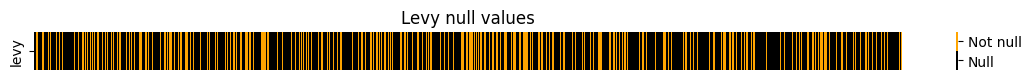

In [11]:
fig, ax = plt.subplots(figsize=(14, 0.5))

bin_cmap = LinearSegmentedColormap.from_list('binWhiteBlack', ['orange', 'black'], 2)
sns.heatmap(data[['levy']].isna().T,  cmap=bin_cmap.reversed())

ax.set_xticks([])
ax.set_title('Levy null values')
fig.get_axes()[-1].set(yticks=[0.25, 0.75], yticklabels=['Null', 'Not null']);

The "levy" column has about $30\%$ of null values, which we'll have to handle later when we create a pipeline for the preprocessing.

In [12]:
cat_features = ['category', 'manufacturer', 'model', 'fuel_type', 
                'gear_box_type', 'drive_wheels', 'doors', 'wheel', 
                'color']

features_with_outliers = ['mileage', 'airbags', 'engine_volume', 'cylinders']

### Outliers

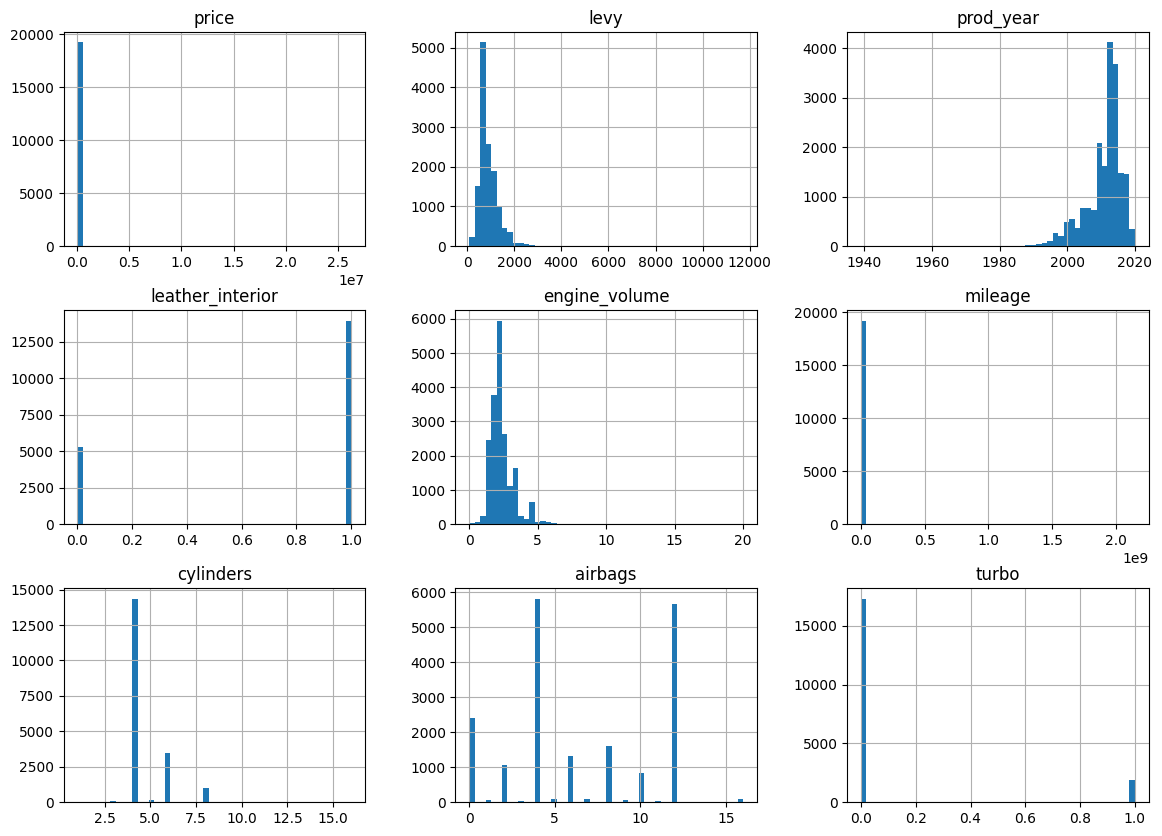

In [13]:
data.hist(bins=50, figsize=(14, 10));

Almost all the columns are skewd, probably because of outliers. 

In particular, the "price" column ranges from 1 to more than 25 millions dollars. Since this column is our target, we'll just use the cars with prices between the 5th and the 95th percentiles (i.e., between 314 and 49459 dollars).

In [14]:
lower_price_lim, upper_price_lim = data.price.quantile([0.05, 0.95])

data = (
    data[(lower_price_lim<data.price)*(data.price < upper_price_lim)]
    .reset_index()
    .drop(columns='index')
)


Let's plot the price distribution.

<Axes: xlabel='Price', ylabel='Density'>

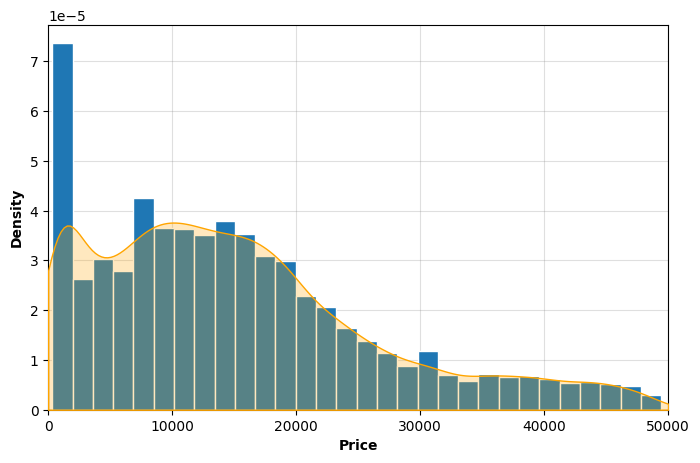

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(data.price, bins=30, zorder=5, density=True, edgecolor=(1, 1, 1))
ax.grid(color='gray', alpha=0.25, zorder=0)
ax.set_xlabel('Price', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.set_xlim(0, 50000)
sns.kdeplot(data.price, zorder=15, fill=True, color='orange', clip=[0, 5e4])

### Train/test split

Before we continue, let's split our dataset into the train and test set. This way, we can create a pre-processing pipeline with just the train set, and we can do exploratory data analysis without lookint at the test set.

In [16]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)
data_train.shape, data_test.shape

((12854, 18), (4285, 18))

<br><strong style='border: 2px solid darkblue; border-radius:0em; color:darkred; padding: 1em 5em; margin:0em; text-align:center; font-size: 1.5em'> 2. Exploratory Data Analysis </strong><br><br>

### Feature correlations

Text(0.0, 1.0, 'Correlation matrix')

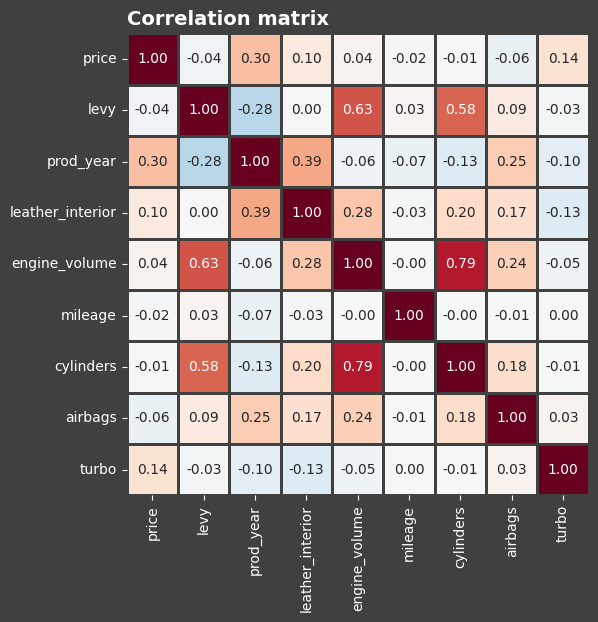

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.set_facecolor('0.25')
ax.set_facecolor('0.25')

corr_mat = data_train.corr(numeric_only=True)
mask = ~np.tril(np.ones_like(corr_mat)).astype(bool)

sns.heatmap(corr_mat, cmap='RdBu_r', vmin=-1, vmax=1, square=True,
            annot=True, fmt='.2f', xticklabels=corr_mat.columns, 
            yticklabels=corr_mat.columns, linewidth=1, 
            linecolor='0.25', cbar=False)

ax.tick_params(labelcolor='white', color='white')
ax.set_title('Correlation matrix', fontsize=14, fontweight='bold', color='white', 
             loc='left')

The only feature with a high correlation with the price is the **prod_year**. All other features have a correlation with price near or lower than $0.10$. 
Other than this, there a just a few highly correlated features. In particular, the number of **cylinders** is highly correlated with the **engine_volume** (we could expect bigger engines to have a high number of cylinders). Also, there is no high correlation between the **price** and the **levy**, and even the **prod_year** has a negative correlation with the **prod_year** (older cars pay more **levy**).

Price statistics
--------------------
count    12854.000000
mean     15181.356387
std      11413.182604
min        330.000000
25%       6586.000000
50%      13328.000000
75%      21012.000000
max      49293.000000
Name: price, dtype: float64


Text(0.5, 0, 'Price')

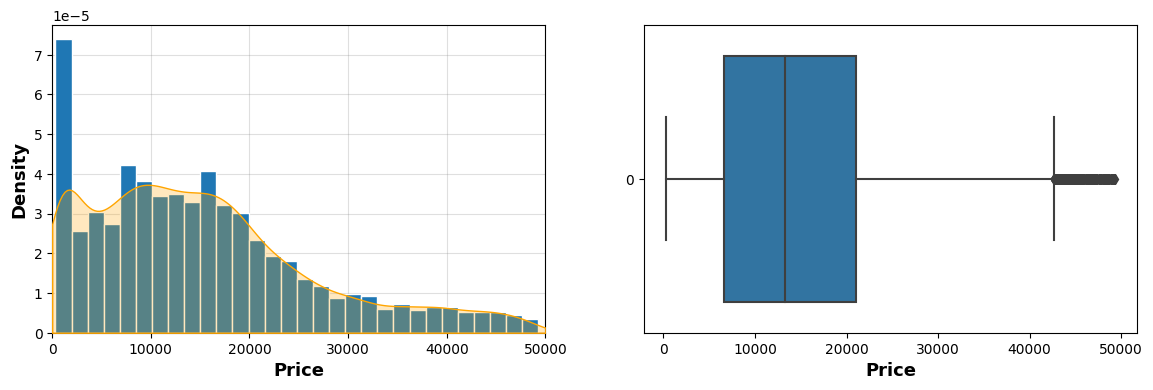

In [18]:
print('Price statistics', '-'*20, data_train.price.describe(), sep='\n')

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax.hist(data_train.price, bins=30, zorder=5, density=True, edgecolor=(1, 1, 1))
ax.grid(color='gray', alpha=0.25, zorder=0)
ax.set_xlabel('Price', fontweight='bold', fontsize=13)
ax.set_ylabel('Density', fontweight='bold', fontsize=13)
ax.set_xlim(0, 50000)
sns.kdeplot(data_train.price, zorder=15, fill=True, color='orange', clip=[0, 5e4], ax=ax)

sns.boxplot(data_train.price.values, orient='horizontal', color='C0', ax=ax2)
ax2.set_xlabel('Price', fontweight='bold', fontsize=13)

The car prices ranges from about 330 to 49300 dollars, with a mean of about 13328 dollars. Also, the prices are right-skewed, with only 25% of cars with a price greater than 21000 dollars, and a lot of cars with a price less than 1000 dollars.

In [19]:
data_train[data_train.price<1000].sample(10, random_state=25).sort_values(by='prod_year', ascending=False)

,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,turbo
7550,549,1079.0,TOYOTA,CHR,2018,Jeep,1,Petrol,2.0,46733.0,4.0,Automatic,Front,04-May,Left wheel,Silver,12,0
844,470,1017.0,MERCEDES-BENZ,E 300,2017,Sedan,1,Petrol,2.0,35874.0,4.0,Automatic,4x4,04-May,Left wheel,Black,12,0
15962,392,690.0,LEXUS,RX 450,2016,Jeep,1,Hybrid,3.5,27038.0,6.0,Automatic,4x4,04-May,Left wheel,White,12,0
3806,392,690.0,LEXUS,RX 450,2016,Jeep,1,Hybrid,3.5,27038.0,6.0,Automatic,4x4,04-May,Left wheel,White,12,0
5671,627,397.0,LEXUS,CT 200h,2016,Hatchback,1,Hybrid,1.8,85320.0,4.0,Automatic,Front,04-May,Left wheel,Red,0,0
44,862,1104.0,AUDI,Q7,2015,Jeep,1,Petrol,3.0,264014.0,6.0,Automatic,4x4,04-May,Left wheel,Black,0,0
16855,627,1604.0,MERCEDES-BENZ,E 350,2014,Sedan,1,Diesel,5.5,101424.0,8.0,Automatic,4x4,04-May,Left wheel,Grey,12,0
13144,862,530.0,MINI,Cooper S Cabrio,2013,Hatchback,1,Petrol,1.6,0.0,4.0,Automatic,Front,04-May,Left wheel,Black,12,0
8294,470,753.0,HYUNDAI,Sonata,2012,Jeep,1,Hybrid,2.4,123862.0,4.0,Automatic,Front,04-May,Left wheel,White,0,0
15038,862,1399.0,MERCEDES-BENZ,E 350,2010,Sedan,1,Diesel,3.5,239224.0,6.0,Automatic,4x4,04-May,Left wheel,Black,12,0


Looking at some cars with prices lower than 1000 dollars, we found some luxury brands like Mercedez-Benz or Audi, as well as relatively new cars (a 2018 Toyota C-HR for instance), whose prices are likely to be incorrect.

In [20]:
data_train[data_train.price<1000].groupby('manufacturer')['manufacturer'].count().sort_values(ascending=False).head(10)

manufacturer
TOYOTA           301
LEXUS            165
MERCEDES-BENZ    137
HYUNDAI           83
FORD              58
CHEVROLET         51
HONDA             46
BMW               45
NISSAN            33
MAZDA             30
Name: manufacturer, dtype: int64

In fact, Lexus and Mercedez-benz (two brands considered as luxury) are the 2nd and 3rh most found brands, respectively, with prices lower than 1000 dollars, which tells us that there are many incorrect prices (at least near the lower limit).

### most and least used car brands for sale

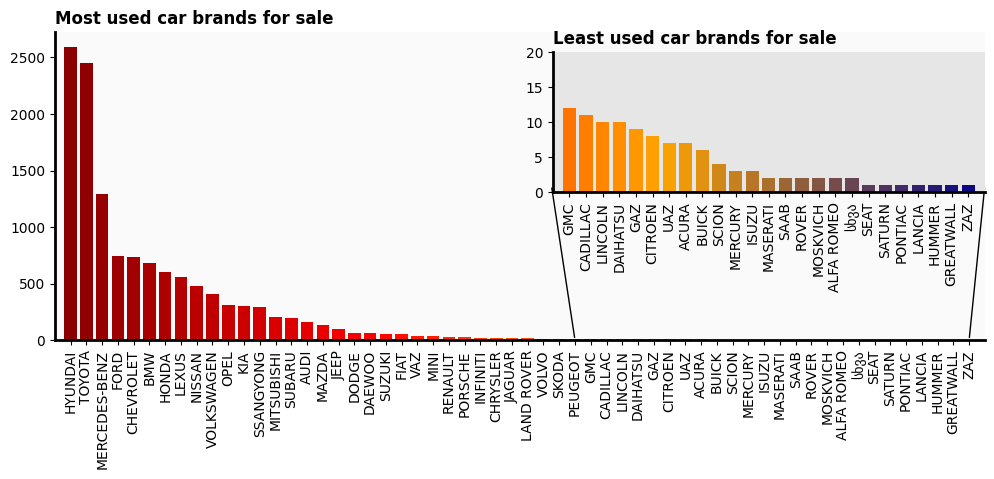

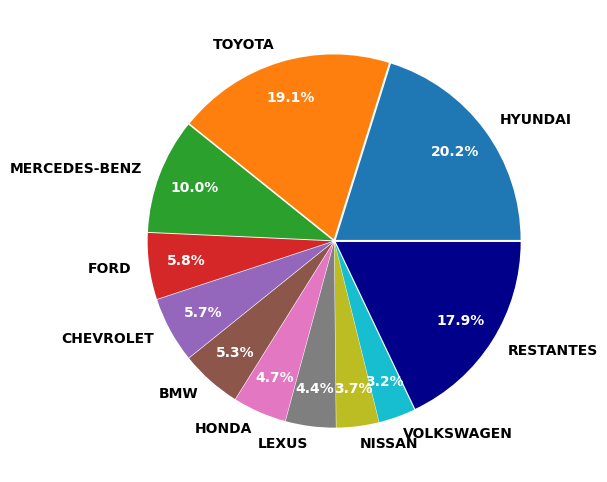

In [21]:
top_selling_brands = (
    data_train.groupby(['manufacturer'])['manufacturer']
    .count()
    .sort_values(ascending=False)
)

cmap = LinearSegmentedColormap.from_list('Red2Blue', ['darkred', 'red', 'orange', 'darkblue'])
colors = cmap(np.arange(top_selling_brands.size)/top_selling_brands.size)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 4))

# Main figure
bars = ax.bar(top_selling_brands.index, top_selling_brands)
ax.set_xlim(-1, len(top_selling_brands))

# Zoom figure
axz = fig.add_axes([0.54, 0.48, 0.36, 0.35])
barsz = axz.bar(top_selling_brands[-25:].index, top_selling_brands[-25:])
axz.set_ylim(0, 20)
axz.set_xlim(-1, 25)

    
ax.tick_params(axis='x', rotation=90)
axz.tick_params(axis='x', rotation=90)
for spin in ax.spines:
    if spin in ['bottom', 'left']:
        ax.spines[spin].set(lw=2, )
        axz.spines[spin].set(lw=2)
    else:
        ax.spines[spin].set(visible=False)
        axz.spines[spin].set_visible(False)


# Customize bar colors
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)
    
for barz, color in zip(barsz, colors[-len(barsz):]):
    barz.set_facecolor(color)
    
ax.annotate(text='', xy=(30.5, 1370), xytext=('PEUGEOT', 0), arrowprops={'arrowstyle':'-'})
ax.annotate(text='', xy=(58, 1370), xytext=('ZAZ', 0), arrowprops={'arrowstyle':'-'})

axz.set_title('Least used car brands for sale', fontweight='bold', loc='left')
axz.set_facecolor('0.9')
ax.set_title('Most used car brands for sale', fontweight='bold', loc='left' )
ax.set_facecolor('0.98')


# PIE PLOT
top_selling_brands_2 = top_selling_brands[:10]
top_selling_brands_2['RESTANTES'] = (top_selling_brands[10:].sum())

fig, ax = plt.subplots(figsize=(6, 6))
pie_elements = plt.pie(top_selling_brands_2/top_selling_brands_2.sum(), 
                        labels=top_selling_brands_2.index, 
                        autopct=lambda p: '{:.1f}%'.format(p),
                        textprops={'weight': 'bold'}, 
                        pctdistance=0.8, 
                        explode=[0.01]*top_selling_brands_2.size)

pie_elements[0][-1].set_facecolor('darkblue')
for label in pie_elements[2]:
    label.set(color='white')

Hyundai, Toyota and Mercedes-Benz are the top three manufacturers with used cars for sale, followed by Ford, Chevrolet, BMW, Honda, Lexus, Nissan and Volkswagen. Together, these 10 manufacturers have more than 80% of the market.

On the other hand, the manufacturers with less used cars for sale are Zaz, Greatwall, Hummer, Lancia, Pontiac, Saturn and Seat, with just one car in the (train) dataset. Some of these manufacturers are from Europe, and are little known in America (ZaZ, Saturn, Greatwall, Lancia), while others no longer sale in the United States.

Text(0.0, 1.0, 'Most used cars models for sale')

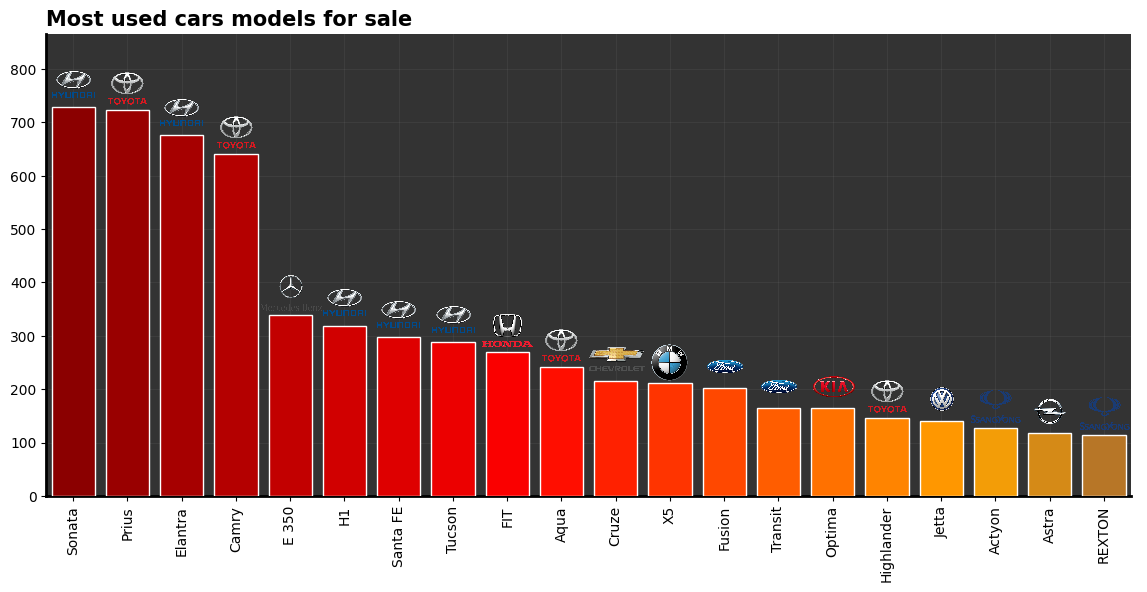

In [22]:
models_for_sale = (
    data_train.groupby(['manufacturer', 'model'])
    .count()
    .loc[:, 'price']
    .sort_values(ascending=False)
).reset_index().rename(columns={'price':'counts'})
#models_for_sale = models_for_sale.rename(columns={'price':'count'})

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(models_for_sale[:20].model, models_for_sale[:20].counts, zorder=10)
ax.set_xlim(-0.5, 19.5)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+100)
ax.tick_params(axis='x', rotation=90)

for bar, color in zip(bars, cmap(np.arange(20)/25)):
    bar.set(facecolor=color, edgecolor='white', linewidth=1)
    
for bar, manuf in zip(bars, models_for_sale[:20].manufacturer):
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height() + 40
    zooms = {'MERCEDES-BENZ': 0.029, 'BMW':0.013, 'FORD': 0.027, 'OPEL': 0.023, 
             'TOYOTA': 0.022}
    zoom = zooms[manuf] if manuf in zooms else 0.017
    logo = AnnotationBbox(OffsetImage(brand_logos[manuf], zoom=zoom), 
                          (x, y), frameon=False, zorder=20)
    ax.add_artist(logo)
    
ax.set_facecolor('0.2')
ax.grid(color='white', alpha=0.05, zorder=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_lw(2)
ax.spines['left'].set_lw(2)

ax.set_title('Most used cars models for sale', fontsize=15, 
             fontweight='bold', loc='left')

### Leather interiors

Text(0.13, 0.98, 'Has leather interior?')

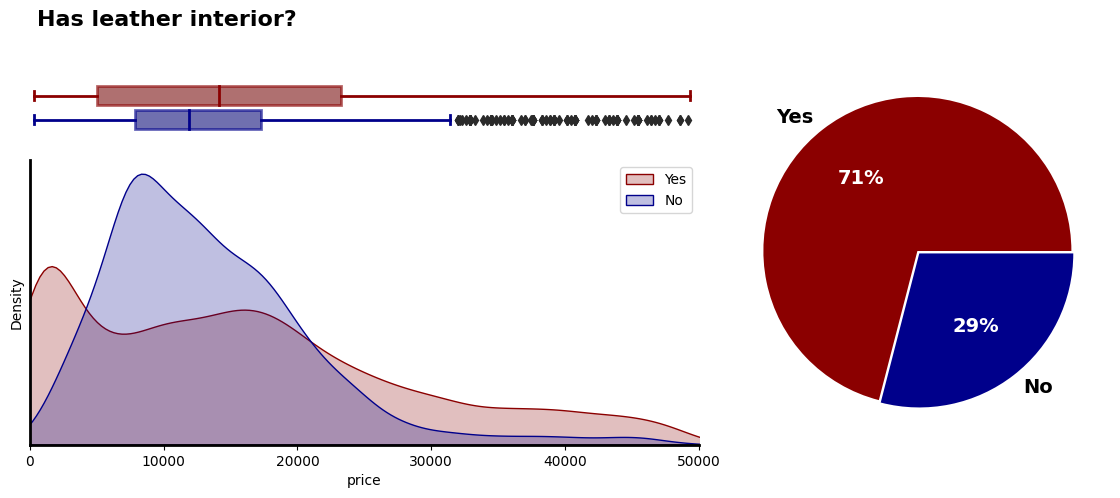

In [23]:
# Create figure and subplots
fig = plt.figure(figsize=(14, 5))

gs = plt.GridSpec(4, 8)
ax1 = fig.add_subplot(gs[0, :5])
ax2 = fig.add_subplot(gs[1:, :5])
ax3 = fig.add_subplot(gs[:, 5:])

# Create and customize boxplots
boxplot_ems =sns.boxplot(data_train, 
                    orient='horizontal', ax=ax1, x='price', 
                    y='leather_interior', linewidth=2, palette=['darkblue', 'darkred'])

boxplot_ems.get_children()[0].set(alpha=0.6, edgecolor='darkblue')
for element in boxplot_ems.get_children()[1:7]:
    element.set(color='darkblue', lw=2)
for element in boxplot_ems.get_children()[8:14]:
    element.set(color='darkred', lw=2)
boxplot_ems.get_children()[7].set(alpha=0.6, edgecolor='darkred', lw=2)

ax1.set(xticks=[], xlabel='', ylabel='', ylim=(-1, 2.5), yticks=[])
#ax1.set_yticklabels(['No', 'Yes'])


# Create and customize KDE Plots 
sns.kdeplot(data_train[data_train.leather_interior==1].price, 
            label='Yes', fill=True, ax=ax2, clim=(0, 5e4), color='darkred')
sns.kdeplot(data_train[data_train.leather_interior==0].price, 
            label='No', fill=True, ax=ax2, clim=(0, 5e4), color='darkblue')

for spin in ax1.spines:
    ax1.spines[spin].set_visible(False)
    if spin in ['right', 'top']:
        ax2.spines[spin].set_visible(False)
    else:
        ax2.spines[spin].set_linewidth(2)

# Set lims and legend()
ax2.set_xlim(-10, 5e4)
ax2.set_yticks([])
ax1.set_xlim(ax2.get_xlim())

# Create Pie plot
has_leather_interior = data_train['leather_interior'].value_counts()
pie_elements = ax3.pie(has_leather_interior, labels=['Yes', 'No'], colors=['darkred', 'darkblue'], 
                        explode=[0.01, 0.01], autopct=lambda p: f'{p:2.0f}%', 
                        textprops={'weight': 'bold', 'fontsize':14})
for text in pie_elements[-1]:
    text.set_color('white')

ax2.legend()
fig.suptitle('Has leather interior?', fontsize=16, fontweight='bold', x=0.13, ha='left')

In [24]:
mean_median = (
    pd.DataFrame(data_train.groupby('leather_interior').price.aggregate([np.mean, np.median]))
        .rename(columns=lambda col: f'{col}_price', 
                index=lambda idx: 'Yes' if idx else 'No')
)
mean_median

,mean_price,median_price
leather_interior,,
No,13397.840793,11917.0
Yes,15910.754248,14113.0


More than$70\%$ of used cars sold have leather interiors. Although the average price of cars with leather interiors is higher than those without leather interiors ($\$13,397$ vs. $\$15,910$), both distributions are skewed to the right, so we can find cars with leather interiors even in low-cost used cars.

Text(0.0, 1.0, 'Percentage of cars with leather interiors by price \n')

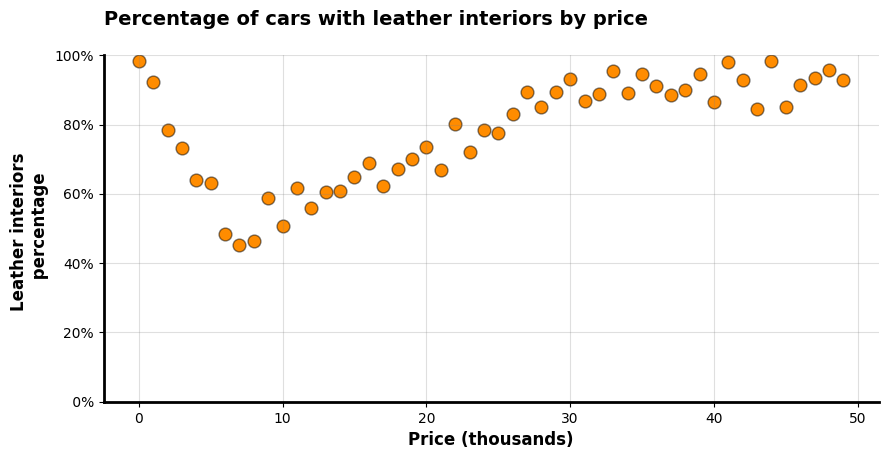

In [25]:
leather_by_price_thousands = (
    data_train.assign(price_in_thousands=data_train.price//1000)
    .groupby('price_in_thousands')
    .leather_interior
    .aggregate(['mean', 'count'])
)

fig, ax = plt.subplots(figsize=(10, 4.5))
ax.scatter(leather_by_price_thousands.index, 100*leather_by_price_thousands['mean'], 
           c='darkorange', s=85, edgecolor=(0, 0, 0, 0.5))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda yi, lab: f'{yi:2.0f}%'))
ax.set_xlabel('Price (thousands)', fontsize=12, fontweight='bold')
ax.set_ylabel('Leather interiors \n percentage', fontsize=12, fontweight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.grid(alpha=0.25, color='gray')
ax.set_ylim(0, 100)
ax.set_title('Percentage of cars with leather interiors by price \n', loc='left', 
             fontsize=14, fontweight='bold')

For less than 5 thousands dollars, more than $50\%$ of the cars have leather interiors, however, for used cars that cost around 7 or 8 thousands dollars, less than $50\%$ cars have leather interiors. Again, this is most likely due to incorrect pricing at the lower limit.

Despite this, as the price increases, the percentage of cars with leather interior also increases. At around the $ \$25000$, more than $80\%$ of the cars have leather interiors.



In [26]:
pct_leather_by_manufacturer = data_train.groupby('manufacturer')['leather_interior'].mean().sort_values(ascending=False)
total_by_manufacturer = data_train.groupby('manufacturer')['manufacturer'].count()

df_leather = (
    pd.DataFrame({'pct_leather_interior': pct_leather_by_manufacturer, 
                  'total_cars_on_sale': total_by_manufacturer})
    .sort_values(by=['pct_leather_interior', 'total_cars_on_sale'], ascending=False)
)

Text(0.0, 1.0, '    Percentage of cars with leather interior by manufacturer')

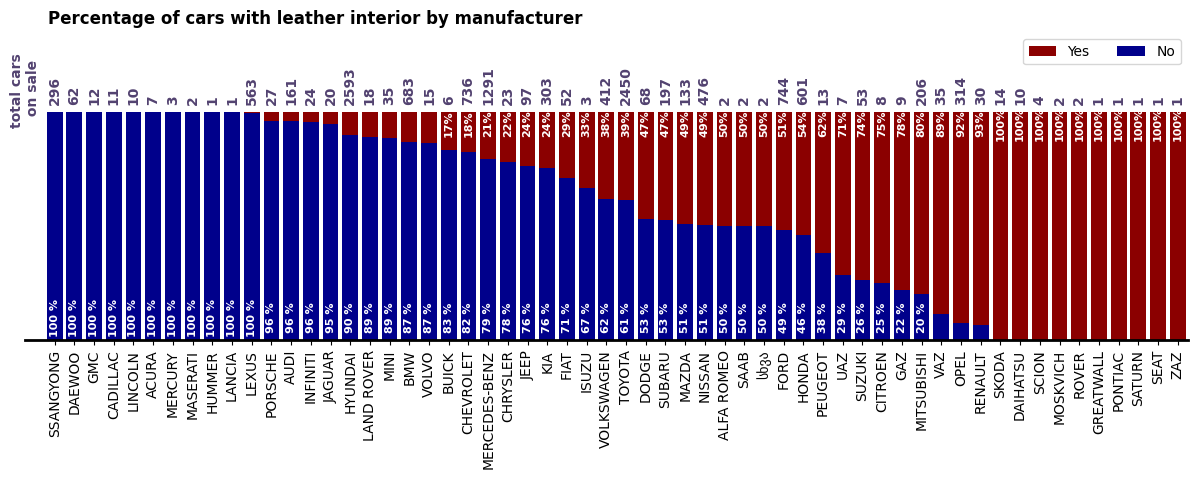

In [27]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.bar(df_leather.index, [100]*df_leather.shape[0], color='darkred', label='Yes')
pct_bars = ax.bar(df_leather.index, 100*df_leather['pct_leather_interior'], color='darkblue', label='No')
ax.legend(loc='upper right', ncols =2)

ax.set_yticks([])
ax.set_ylim(0, 135)
ax.set_xlim(-1.5, df_leather.shape[0]-0.5)
ax.tick_params(axis='x', rotation=90)

for spin in ax.spines:
    if spin in ['bottom']:
        ax.spines[spin].set(lw=2)
    else:
        ax.spines[spin].set_visible(False)
        
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda yi, li: f'{yi:2.0f}%'))

for bar, manufacturer in zip(pct_bars, df_leather.index):
    pct = bar.get_height()
    x = bar.get_x() + bar.get_width()/2
    if pct >= 15:
        ax.annotate(text=f'{pct:2.0f} %', xy=(x, 10), rotation=90, 
                    ha='center', va='center', color='white', fontweight='bold', 
                    fontsize=8)
    if pct<85:
        ax.annotate(text=f'{100-pct:2.0f}%', xy=(x, 95), rotation=90, 
                    ha='center', va='center', color='white', fontweight='bold', 
                    fontsize=8)
    
    total_cars = df_leather.loc[manufacturer, 'total_cars_on_sale']
    ax.annotate(text=f'{total_cars}', xy=(x, 103), ha='center', va='bottom', 
               rotation=90, fontweight='bold', color='#524270')
    
ax.annotate(text='total cars\n on sale', xy=(-1.5, 93), rotation=90, ha='center', 
            va='bottom', fontweight='bold', color='#524270')
        
ax.set_title('    Percentage of cars with leather interior by manufacturer', loc='left', 
              fontweight='bold')

All the used cars of the manufacturers SSangYong, Daewoo and GMC (together with other brands with little used cars for sale) use leather interiors. Other than these, luxury manufacturers like lexus, porsche, audi, infiniti, jaguar, land-rover, among others have the higher percentages (higher than $90\%$ of the cars) of cars with lether interiors.

### **Levy**

In [28]:
data_train_notna = data_train.dropna()

print('pct less than 1000 dollars: {:2.1f}%'.format(100*data_train_notna['levy'].lt(1500).mean()))
pd.DataFrame(data_train_notna['levy'].aggregate(['min', 'median', 'max', 'mean', 'skew']))

pct less than 1000 dollars: 92.9%


,levy
min,87.000000
median,779.000000
max,11706.000000
mean,887.706112
skew,4.764064


The levy ranges from $\$87$ to $\$11,706$, with a mean of $\$888$ and a median of $\$799$. Also, the distribution is posfitively skewd (${\rm skew} = 4.8$), so almost all of the cars ($ \approx 93\%$) have to pay a levy less than 1500 dollars.

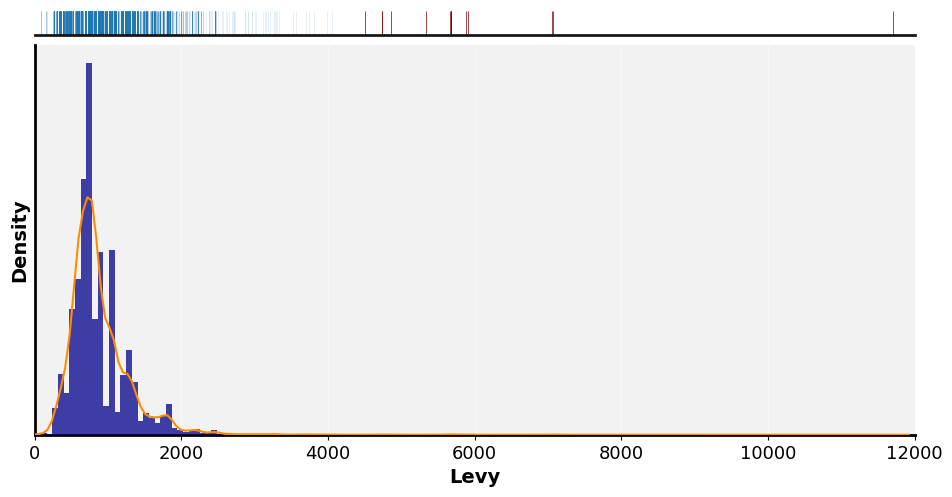

In [29]:
fig = plt.figure(figsize=(11, 5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.78])
axt = fig.add_axes([0.1, 0.9, 0.8, 0.05])

ax.hist(data_train_notna['levy'], bins=150, zorder=3, density=True, 
        color='darkblue', alpha=0.75)
sns.kdeplot(data_train_notna['levy'], color='darkorange', zorder=5, 
            ax=ax)
ax.set_facecolor('0.95')
ax.grid(color='white', alpha=0.5, zorder=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set(lw=2)
ax.spines['left'].set(lw=2)
ax.set_yticks([])
ax.tick_params(labelsize=13)
ax.set_xlabel('Levy', fontweight='bold', fontsize=14)
ax.set_ylabel('Density', fontweight='bold', fontsize=14)
ax.set_xlim(0, 12000)
axt.set(xlim=ax.get_xlim(), xticks=[], yticks=[])

axt.vlines(x=data_train_notna.levy.values, ymin=0, ymax=1, alpha=0.15, 
           lw=0.5)
axt.vlines(x=data_train_notna.levy[data_train_notna.levy>4500], 
           ymin=0, ymax=1, color='darkred', lw=0.5, alpha=1)
for spin in axt.spines:
    if spin != 'bottom':
        axt.spines[spin].set_visible(False)
    else:
        axt.spines[spin].set(lw=2, alpha=0.9)

Almost all cars have a Levy between $\$0$ and $\$2500$. However, some car's Levy goes even higher than $\$10000$ dollars.

In [30]:
levy_by_manufacturer = pd.DataFrame(
    data_train_notna.groupby('manufacturer')['levy']
    .mean()
    .sort_values(ascending=False)
).reset_index()


Text(0.0, 1.0, 'Mean levy by manufacturer')

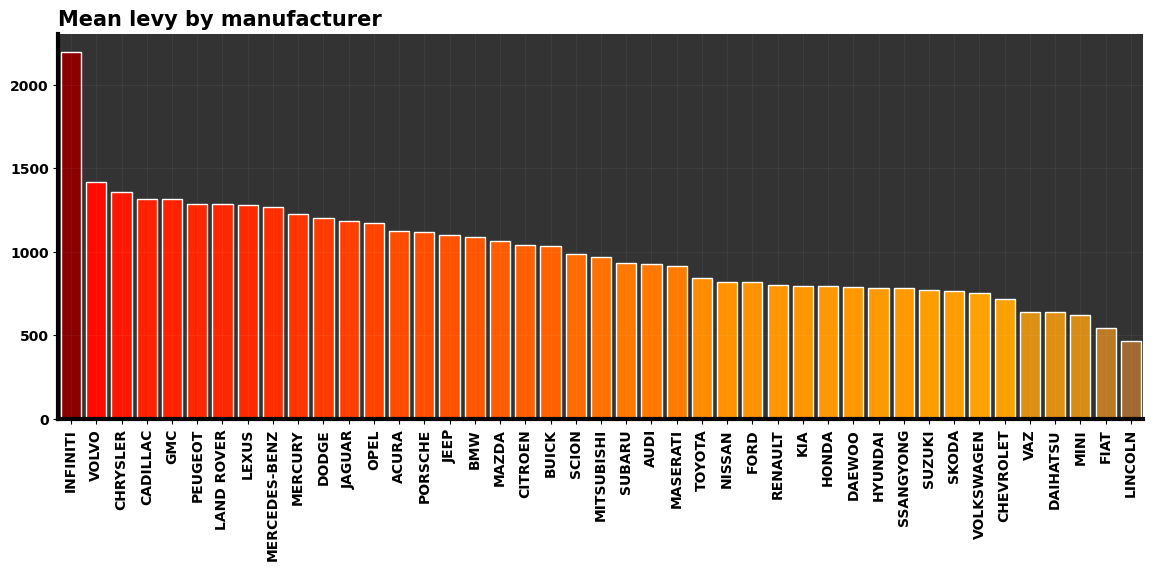

In [31]:
fig, ax = plt.subplots(figsize=(14, 5))

bars = ax.bar(levy_by_manufacturer['manufacturer'], levy_by_manufacturer['levy'], 
              color='darkblue', edgecolor='white')
ax.set_xlim(-0.5, len(bars)-0.5)
ax.tick_params(axis='x', rotation=90)
ax.set_facecolor('0.2')
ax.grid(color='white', alpha=0.05, ls='-', zorder=0)

colors = cmap(1 - levy_by_manufacturer.levy / levy_by_manufacturer.levy.max())
for color, bar in zip(colors, bars):
    bar.set_facecolor(color)
    
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_linewidth(3)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')
    
ax.set_title('Mean levy by manufacturer', loc='left', fontweight='bold', 
             fontsize=15)

correlation: 0.184


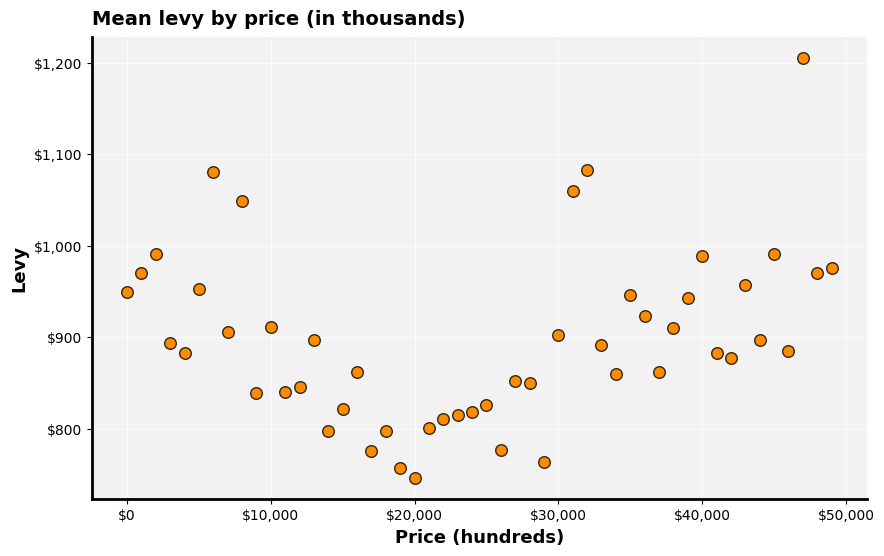

In [32]:
levy_by_price_thousands = (
    data_train_notna.assign(price_in_thousands=(data_train_notna.price/1000).round())
    .groupby('price_in_thousands')
    .levy
    .mean()
)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(levy_by_price_thousands.index, levy_by_price_thousands.values, 
         color='darkorange', edgecolor=(0, 0, 0, 0.8), zorder=4, s=70)

ax.set_facecolor('0.95')
ax.grid(color='white', alpha=0.75, zorder=0)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_lw(2)

ax.set_xlabel('Price (hundreds)', fontsize=13, fontweight='bold')
ax.set_ylabel('Levy', fontsize=13, fontweight='bold')
ax.set_title('Mean levy by price (in thousands)', loc='left', fontweight='bold', 
              fontsize=14, va='bottom')

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda xi, lab: f'${xi*1000:,.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda yi, lab: f'${yi:,.0f}'))

correlation = np.corrcoef(levy_by_price_thousands.index, levy_by_price_thousands.values)[0, 1]
print(f'correlation: {correlation:0.3f}')

Altough the manufacturers that pay most levy are considered as premium or luxury (Infinity, Volvo, Chrysler, Cadilla, etc.), there are also luxury brands with low levy (Lincon, for instance, occupies the last position), however, this could be either due to incorrect/null values or because the sample for these manufacturers is small and non-representative. 

In general, we can note a little tendency for luxury brands to pay higher levies. However, it doesn't seem to be a linear correlation between the price of the cars and it's levy (r=0.19), but levy increases as the price both increases and decreases from $\$20,000$. As we know that Levy is calculated as a percentage of the price of the car, again, this result might suggest that a large number of low-priced cars is incorrectly priced.

# 

### **Production year**

In [33]:
pd.DataFrame(
    data_train
    .prod_year
    .aggregate(['min', 'mean', 'median', 'max', 'skew'])
)

,prod_year
min,1953.000000
mean,2010.693092
median,2012.000000
max,2020.000000
skew,-1.590933


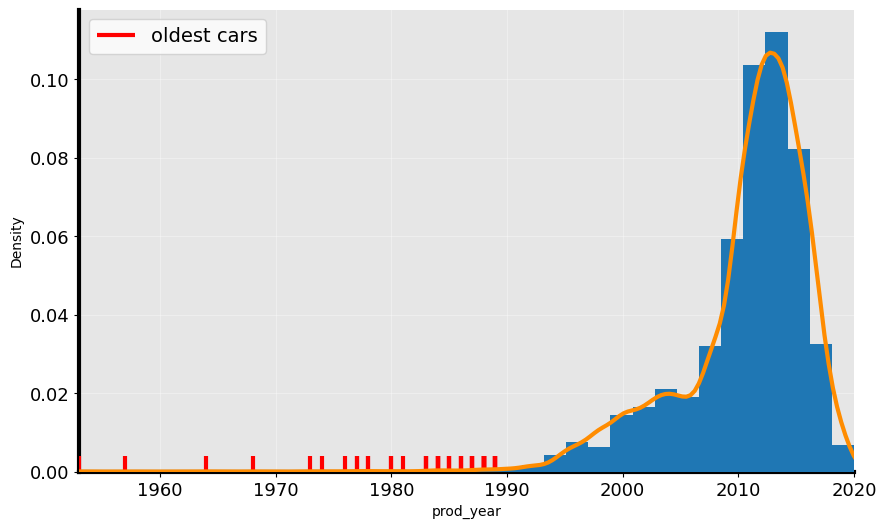

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.vlines(data_train[data_train.prod_year<1990].prod_year,  ymin=0, ymax=0.004, 
          color='red', label='oldest cars', lw=3, zorder=5)
ax.hist(data_train.prod_year, bins=35, density=True, zorder=5)
sns.kdeplot(data_train.prod_year, color='darkorange', lw=3, zorder=5)
ax.set_xlim(data_train.prod_year.min(), 2020)

ax.legend(fontsize=14)

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['bottom', 'left']].set_linewidth(3)
ax.set_facecolor('0.9')
ax.grid(color='white', zorder=0, alpha=0.35)
ax.tick_params(labelsize=13)

In [35]:
print('No. of cars produced before 1990: ', 
       data_train[data_train.prod_year<1990].shape[0])
print('\nOldest used cars on sale', '='*40, sep='\n')
(
    data_train[data_train.prod_year<1990][['manufacturer', 'model', 'prod_year']]
    .sort_values(by='prod_year')
    .head(15)
)

No. of cars produced before 1990:  46

Oldest used cars on sale


,manufacturer,model,prod_year
16961,GAZ,20,1953
8462,UAZ,31514,1957
10617,GAZ,21,1964
11332,UAZ,31514,1968
15676,CHEVROLET,Impala,1973
7654,VAZ,2106,1974
7964,OPEL,Crossland X,1976
15364,VAZ,2106,1977
405,GAZ,32214,1977
6044,MOSKVICH,2140,1978


Text(0, 1, 'Main manufacturers for old vs new cars\n\n')

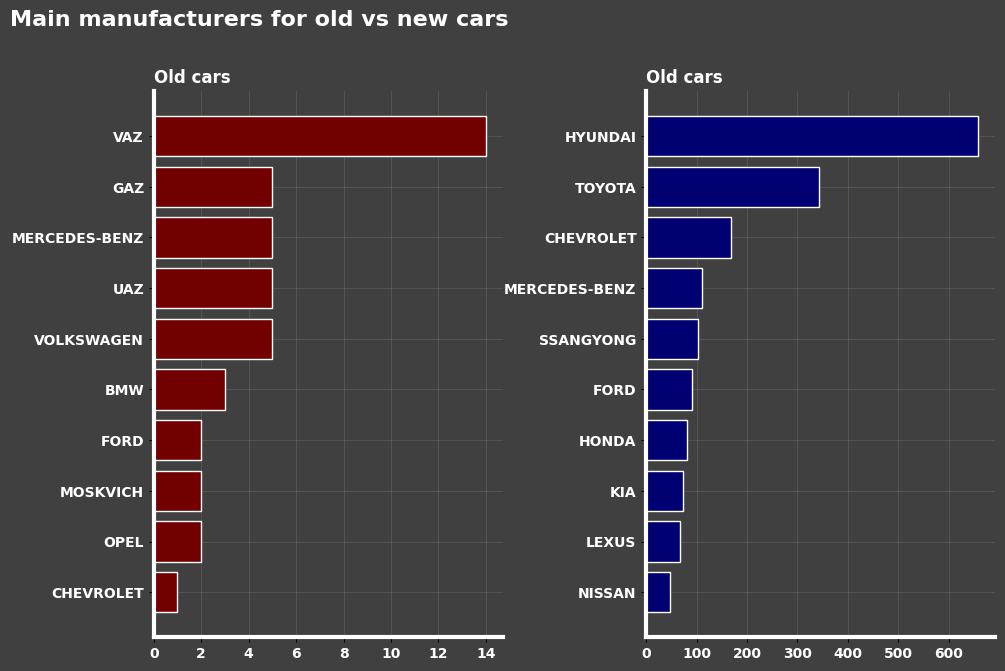

In [36]:
manuf_of_oldest_cars = (
    data_train[data_train.prod_year<1990]
    .groupby('manufacturer')['manufacturer']
    .value_counts()
    .sort_values(ascending=False)
)

manuf_of_newest_cars = (
    data_train[data_train.prod_year>2015]
    .groupby('manufacturer')['manufacturer']
    .value_counts()
    .sort_values(ascending=False)
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.barh(manuf_of_oldest_cars[:10].index, manuf_of_oldest_cars[:10].values, 
         color=(0.45, 0, 0), edgecolor='white', zorder=5)
ax2.barh(manuf_of_newest_cars[:10].index, manuf_of_newest_cars[:10].values, 
         color=(0, 0, 0.45), edgecolor='white', zorder=5)

plt.tight_layout()

fig.set_facecolor('0.25')
for ax in (ax1, ax2):
    ax.set_facecolor('0.25')
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['bottom', 'left']].set_linewidth(3)
    ax.spines[['bottom', 'left']].set_zorder(10)
    ax.spines[['bottom', 'left']].set_color('white')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.tick_params(axis='both', labelcolor='white')
    ax.grid(color='white', alpha=0.1, zorder=0)
    
    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontweight('bold')
        
    ax.set_title('Old cars', color='white', 
                 fontweight='bold', loc='left')
        
plt.suptitle('Main manufacturers for old vs new cars\n\n', x=0, y=1, 
             ha='left', color='white', fontweight='bold', 
             va='bottom', fontsize=16)


The production year of used cars on the market ranges from 1953 to 2020 (we can assume that this data set was created in 2020). The distribution is negatively skewed and, therefore, the mean is between 2010 and 2011, while the median is 2012; That is, $50\%$ of used cars on the market are 8 or less years old since they were produced. On the other hand, there are 46 cars (in the train set) older than 1990, mainly of the manufacuters VAZ, GAZ, UAZ, Mercedes-Benz and Bolkswagen, while for newest cars (newer than 5 years), the main manufacturers are Hyundai, Toyota, Chevrolet, Mercedes-Benz and SSangYong.

Correlation: 0.73


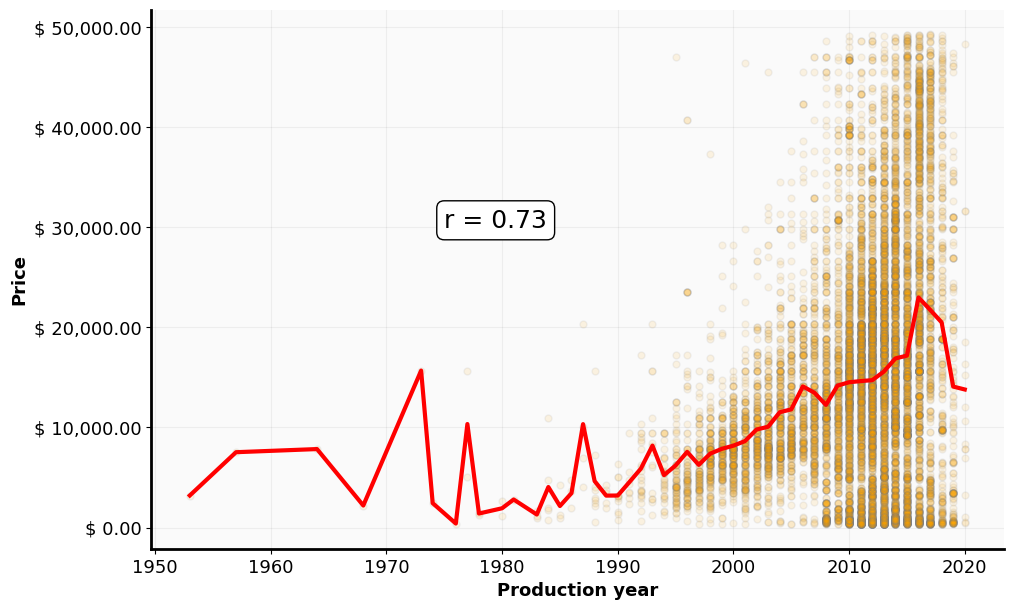

In [37]:
fig, ax = plt.subplots(figsize=(11, 7))

price_per_year = (
    data_train.groupby('prod_year')
    .price.mean()
    .sort_index()
)

ax.scatter(data_train['prod_year'], data_train['price'], color='orange', 
           s=25, alpha=0.1, edgecolor='gray', zorder=5)
ax.plot(price_per_year.index, price_per_year, color='red', lw=3, 
          zorder=5, label='Average price')
ax.grid(color='black', alpha=0.05, zorder=0)
ax.set_facecolor('0.98')

ax.set_ylabel('Price', fontsize=13, fontweight='bold')
ax.set_xlabel('Production year', fontsize=13, fontweight='bold')

ax.spines[['left', 'bottom']].set_lw(2)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=13)

correlation = np.corrcoef(price_per_year.index, price_per_year)[0, 1]
print('Correlation: {:0.2f}'.format(correlation))

ax.annotate(text=f'r = {correlation:0.2f}', xy=(1975, 30000), fontsize=18,
            bbox={'boxstyle':'round', 'facecolor': 'white'})

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda yi, lab: f'$ {yi:,.2f}'))

There is a strong positive linear correlation (r=0.73) between the production year and the price, i.e., newer cars tend to have higher prices. However, here we can see a small clustering between years 2008 and 2019 at low prices, and most of this data is probably from incorrect pricing (although, some of this cars could be low-priced due to cars in a very bad condition).

Before 1990, the number of cars in the data set is small and therefore the line is noisy. However, with older cars we can expect to find both cheap and expensive cars, depending on the condition of the car and the popularity of the model.

### **Engline volume and Turbo**



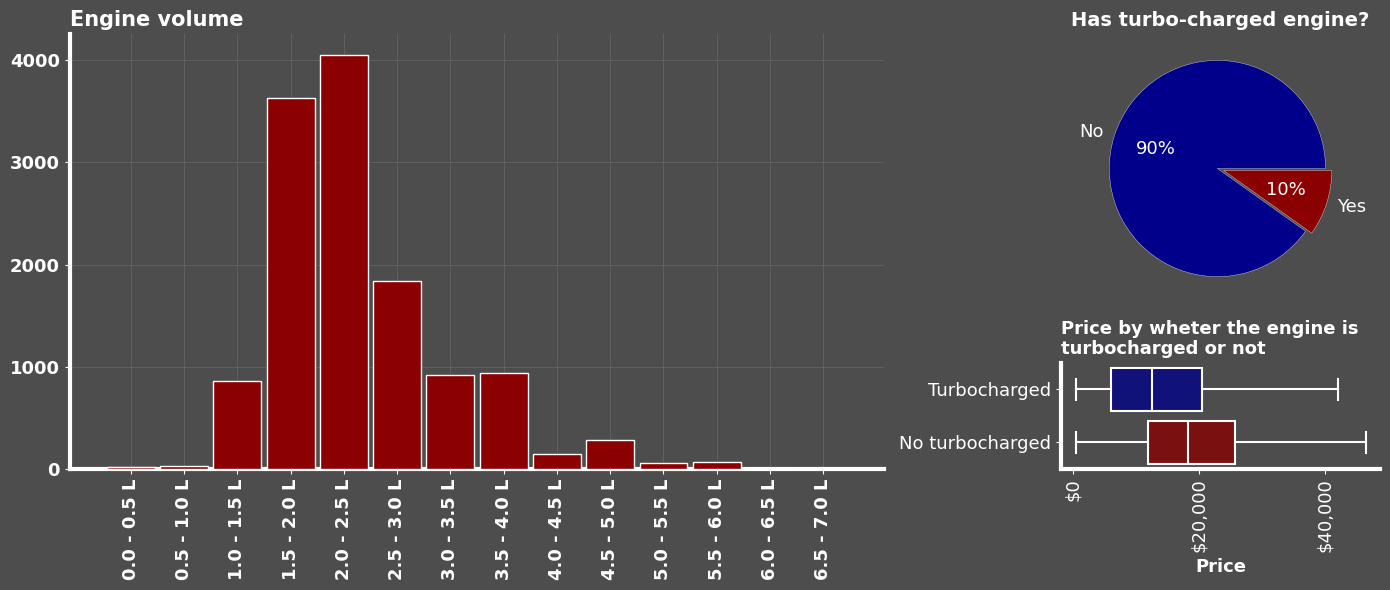

In [38]:
engine_volumen_hist = (
    data_train.engine_volume
    .groupby(np.floor(data_train.engine_volume*2)/2)
    .count()
)
mean_price_by_turbo = data_train.groupby('turbo').price.mean()

fig = plt.figure(figsize=(14, 6))
gs = plt.GridSpec(3, 3)
ax = fig.add_subplot(gs[:, :2])
ax2 = fig.add_subplot(gs[:2, -1])
ax3 = fig.add_subplot(gs[-1, -1])

fig.set_facecolor('0.3')
ax.set_facecolor('0.3')
ax.grid(color='white', alpha=0.1, zorder=0)
ax.bar(engine_volumen_hist.index.astype(str), engine_volumen_hist, width=0.90, 
       color='darkred', edgecolor='white', zorder=5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda xi, lab: f'{xi/2} - {xi/2+0.5} L'))
ax.tick_params(axis='x', rotation=90, color='white')
ax.tick_params(color='white')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color('white')
ax.spines[['bottom', 'left']].set_lw(3)
ax.set_title('Engine volume', loc='left', color='white', fontsize=15, 
             fontweight='bold')

for lab in ax.get_xticklabels()+ax.get_yticklabels():
    lab.set(fontweight='bold', color='white', fontsize=13)
    
    
pie_patches, *_ = ax2.pie(data_train.turbo.value_counts(), 
                         colors=['darkblue', 'darkred'], explode=[0.03, 0.03], 
                         labels=['No', 'Yes'], autopct=lambda p: f'{p:2.0f}%', 
                         textprops={'fontsize': 13, 'color': 'white'})
for patch in pie_patches:
    patch.set_edgecolor('white')
    patch.set_linewidth(0.24)
ax2.set_title('Has turbo-charged engine?', fontsize=14, fontweight='bold', 
              color='white')

ax3.set_facecolor('0.3')
sns.boxplot(data_train, y='turbo', x='price', ax=ax3, palette=['darkblue', 'darkred'], 
            boxprops={'edgecolor': 'white'}, showfliers=False, orient='h')
for child in ax3.get_children():
    if isinstance(child, plt.Line2D):
        child.set_color('white')
ax3.spines[['left', 'bottom']].set_linewidth(3)
ax3.spines[['left', 'bottom']].set_color('white')
ax3.spines[['top', 'right']].set_visible(False)
ax3.tick_params(labelsize=13, labelcolor='white', color='white')
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda xi, li: f'${xi:,.0f}'))
ax3.tick_params(axis='x', rotation=90)
ax3.set_xlabel('Price', fontsize=13, fontweight='bold', color='white')
ax3.set(ylabel='', yticklabels=['Turbocharged', 'No turbocharged'])
ax3.set_title('Price by wheter the engine is \nturbocharged or not', loc='left', 
              fontsize=13, fontweight='bold', color='white')

plt.tight_layout()

In [39]:
def percentile_25(x):
    return x.quantile(.25)

def percentile_75(x):
    return x.quantile(0.75)

pd.DataFrame(
    data_train
    .engine_volume
    .aggregate([ 'mean', 'min', percentile_25, 'median',
                 percentile_75, 'max', 'skew', ])
    .round(2)
)


,engine_volume
mean,2.26
min,0.00
percentile_25,1.80
median,2.00
percentile_75,2.50
max,7.30
skew,1.45


In [40]:
print('Corrleation between turbo and price: ', 
      np.corrcoef(data_train.turbo, data_train.price)[0, 1])

Corrleation between turbo and price:  0.14128932986972398


The engine volume ranges from 0 to 7.30, with a mean of 2.00 and a median of 2.26 (its distribution is positively skewd (${\rm skew}=0.1.45$), so the median is higher than the mean). However, a quick research on the cars with the lowest engine volumes shows that there are just a few cars with engine volume less than 1.0L and, what's more, there are no cars (as far as I have found) with engines less than 0.5L. Also, the engine volumes more common are between 1.0 and 4.0L. What's more, half of the cars have a engine volumne between 1.80 and 2.50L.

On the other hand, only 10% of the used cars for sale have a turbo-charged engine, and those with turbocharged engine are, on average, $37\%$ more expensive than those with no turbocharged engines (there is a positive correlation between cars with turbocharged engines and their price of 0.14).

In [41]:
data_train[data_train.engine_volume<0.5].sample(10)

,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,turbo
13564,549,289.0,FORD,Escape,2008,Jeep,1,Hybrid,0.4,451117.0,4.0,Automatic,Front,04-May,Left wheel,Black,0,0
3998,3293,155.0,VOLKSWAGEN,Jetta,2015,Sedan,1,Diesel,0.2,119394.0,4.0,Automatic,Front,04-May,Left wheel,Black,12,0
1501,549,289.0,FORD,Escape,2008,Jeep,1,Hybrid,0.4,451117.0,4.0,Automatic,Front,04-May,Left wheel,Black,0,0
1901,1333,289.0,FORD,Escape,2008,Jeep,1,Hybrid,0.4,349288.0,4.0,Automatic,Front,04-May,Left wheel,Blue,0,0
627,8154,NaN,MITSUBISHI,Airtrek,2002,Jeep,0,LPG,0.2,18800.0,4.0,Tiptronic,4x4,04-May,Left wheel,Black,2,1
1400,1333,289.0,FORD,Escape,2008,Jeep,1,Hybrid,0.4,349288.0,4.0,Automatic,Front,04-May,Left wheel,Blue,0,0
16523,1333,289.0,FORD,Escape,2008,Jeep,1,Hybrid,0.4,349288.0,4.0,Automatic,Front,04-May,Left wheel,Blue,0,0
6866,47076,87.0,SSANGYONG,REXTON,2016,Jeep,1,Diesel,0.0,73968.0,4.0,Automatic,Front,04-May,Left wheel,Black,4,0
2777,2666,155.0,VOLKSWAGEN,GTI,2015,Hatchback,1,Petrol,0.2,104618.0,4.0,Automatic,Front,04-May,Left wheel,White,12,0
2754,2430,87.0,MERCEDES-BENZ,C 250,2013,Coupe,1,Petrol,0.0,121600.0,4.0,Automatic,Rear,04-May,Left wheel,White,12,0


If we look at a sample of cars with an engine volume of less than 0.5 liters, we can see that they are certainly wrong.

<br><strong style='border: 2px solid darkblue; border-radius:0em; color:darkred; padding: 1em 5em; margin:0em; text-align:center; font-size: 1.5em'> 3. Creating a Machine Learning Model </strong><br><br>

### Preprocessing

In this section, we'll create a pipeline to preprocess the data following the next steps:

1. **Handle infrequent clases.**
2. **Encode categorical features with the OneHotEncoding strategy.**
3. **Handle outliers.**
4. **Impute null values.**
5. **Scale the data.**

First, during the EDA we noted that in the categorical features (mainly in the **model** and **manufacuturer**), some of the classes are very infrequent (with some having just 1 instance). For this, we'll create a transformer to set all this infrequent classes as "other". This transformer have two parameters in its constructor, `n_keep` and `cols`. The former is the min frequency, so that classes with less than this value will be changed as the class 'other', while the second is an optional parameter with the list of feature names that will be used during transforming.

As we noted before, some features have instances with values outside the possible ranges. The engine, for instance, has values near to 0 which are all (or probably allmost all) incorrec, or the number of airbags ranges from 0 to 16, but there are no cars with more than 12 airbags. So, our strategy to handle this outliers is to null them, and then use a KNN imputer to impute this values.


Also, we'll create a last transformer which is basically a copy of the Sklearn's `ColumnTransformer`. This transformer gets a list of feature names in its `all_trans_cols` that will be transformed with transformer in the `transformer` parameter. However, if during training or fitting the data contain less or more features than those in the `all_trans_cols` parameter, the transformer will handle only the features that are both in this data and the `all_trans_cols` attribute.

Finally, we'll create a OutliersNuller transformer to null this outliers. So, this transformer have 3 paramters in its constructos: In its `columns_limits` we can pass it a dictionary with the feature names as keys and a list (lim_inf, lim_sup) to estabilish the limits within normal values should be (all values outside this limits will be set to Nulls). If the limits for some feature (column) is not set in the last attribute, then during fitting, the transformer will set this limits as`std_deviations` standard deviations from the mean. If the `ignore_rest` parameter is True, then all features contained in the X DataFrame during fitting and transforming different than the passed in the constructor via the `column_limits` parameter will be ignored.

To handle the null values, we'll use the sklearn's `KNNImputer`, and to scale the data the `MinMaxScaler` also from sklearn.


In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutliersNuller(TransformerMixin, BaseEstimator):
    def __init__(self, column_limits=None, std_deviations=2, ignore_rest=False):
        self.std_deviations = std_deviations
        self.ignore_rest = ignore_rest
        self.column_limits = column_limits
        if self.column_limits is None:
            self.column_limits = {}
                
    def fit(self, X, y=None):
        if not self.ignore_rest:
            limits = {}

            for col in X.columns:
                data_col = X[col]
                lim_inf = data_col - (self.std_deviations * np.std(data_col))
                lim_sup = data_col + (self.std_deviations * np.std(data_col))
                limits[col] = (lim_inf, lim_sup)

            self.column_limits.update(limits)
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for feature, limits in self.column_limits.items():
            if not feature in X.columns:
                continue
        
            col_feature = X[feature].copy()
            col_feature[col_feature<limits[0]] = np.nan
            col_feature[col_feature>limits[1]] = np.nan
            X[feature] = col_feature
            
        return X

class CreateOthersCat(BaseEstimator, TransformerMixin):
    def __init__(self, n_keep=3, cols=None):
        self.n_keep = n_keep
        self.classes = {}
        self.cols = cols
        
    def fit(self, X, y=None):
        if self.cols is None:
            self.cols = list(X.columns)
            
        for col in self.cols:
            if not col in X.columns:
                continue
            uniques = X[col].value_counts()
            self.classes[col] = list(uniques[uniques>=self.n_keep].index)
            
        return self
    
    def transform(self, X, y=None):
        X_new = X.copy()
        for col, classes in self.classes.items():
            if not col in X_new.columns:
                continue
            X_new[col] = X_new[col].apply(lambda xi: xi if (xi in classes) else 'OTHER')
            
        return X_new
    
    
class SelectedColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, all_trans_cols, transformer):
        self.all_trans_cols = all_trans_cols
        self.fitted_trans_cols = None
        self.transformer = transformer
        
    def fit(self, X, y=None):
        self.fitted_trans_cols = list(set(self.all_trans_cols) & set(X.columns))
        self.transformer.fit(X[self.fitted_trans_cols])
    
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X_transformed = self.transformer.transform(X[self.fitted_trans_cols])
        df_col_names = []
        for col, cats in zip(self.fitted_trans_cols, self.transformer.categories_):
            col_names = [f'{col}_{cat}' for cat in cats]
            df_col_names.extend(col_names)
        
        X = X.drop(columns=self.fitted_trans_cols)
        all_df_col_names = list(X.columns) + df_col_names
        X_all = np.concatenate([X.values, X_transformed], axis=1)
        
        return pd.DataFrame(X_all, columns=all_df_col_names)
        
        
        
class imputerKNN(KNNImputer):
    
    def fit(self, X, y=None):
        super().fit(X, y)
        self.categories = X.columns
        return self
        
    def transform(self, X, y=None):
        Xtrans = super().transform(X)
        Xtrans = pd.DataFrame(Xtrans, columns=self.categories)
        
        return Xtrans
    
    
class ScalerMinMax(MinMaxScaler):
    def fit(self, X, y=None):
        super().fit(X, y)
        self.categories = X.columns
        return self
    
    def transform(self, X):
        Xtrans = super().transform(X)
        Xtrans = pd.DataFrame(Xtrans, columns=self.categories)
        
        return Xtrans

Finally, let's create a pipeline with these three transformers

In [43]:

trans_null_outliers = OutliersNuller({'mileage':(0, 650_000), 
                                      'airbags': (0, 12), 
                                      'engine_volume': (0.5, 9), 
                                      'cylinders': (0, 12)},
                                     std_deviations=2, 
                                     ignore_rest=True)

trans_add_cat_other = CreateOthersCat(cols=['manufacturer', 'model'])
trans_hot_encoder = SelectedColumnTransformer(cat_features, OneHotEncoder(sparse_output=False, handle_unknown='ignore'))

full_trans_pipeline = Pipeline([
    ('add_cat_other', trans_add_cat_other),
    ('encoder', trans_hot_encoder),
    ('nuller', trans_null_outliers), 
    ('imputation', imputerKNN()),
    ('scaler', ScalerMinMax())
])

full_trans_pipeline

Pipeline(steps=[('add_cat_other',
                 CreateOthersCat(cols=['manufacturer', 'model'])),
                ('encoder',
                 SelectedColumnTransformer(all_trans_cols=['category',
                                                           'manufacturer',
                                                           'model', 'fuel_type',
                                                           'gear_box_type',
                                                           'drive_wheels',
                                                           'doors', 'wheel',
                                                           'color'],
                                           transformer=OneHotEncoder(handle_unknown='ignore',
                                                                     sparse_output=False))),
                ('nuller',
                 OutliersNuller(column_limits={'airbags': (0, 12),
                                               'cylinders': (0, 12),
                                               'engine_volume': (0.5, 9),
                                               'mileage': (0, 650000)},
                                ignore_rest=True)),
                ('imputation', imputerKNN()), ('scaler', ScalerMinMax())])

In [44]:
full_trans_pipeline.fit(data_train)
full_trans_pipeline.transform(data_train)

,price,levy,prod_year,leather_interior,engine_volume,mileage,cylinders,airbags,turbo,model_1000,...,fuel_type_LPG,fuel_type_Petrol,fuel_type_Plug-in Hybrid,drive_wheels_4x4,drive_wheels_Front,drive_wheels_Rear,gear_box_type_Automatic,gear_box_type_Manual,gear_box_type_Tiptronic,gear_box_type_Variator
0,0.601740,0.065496,0.910448,1.0,0.220588,0.278612,0.272727,0.000000,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.345547,0.048025,0.865672,1.0,0.191176,0.290618,0.272727,0.833333,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.601740,0.083140,0.910448,1.0,0.441176,0.337151,0.454545,1.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.855503,0.086410,0.940299,1.0,0.294118,0.148286,0.272727,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.027980,0.117497,0.671642,0.0,0.161765,0.461786,0.272727,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12849,0.805098,0.047594,0.895522,1.0,0.220588,0.082018,0.272727,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12850,0.172600,0.047508,0.910448,1.0,0.220588,0.267640,0.272727,0.333333,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12851,0.460838,0.111868,0.865672,1.0,0.132353,0.334950,0.272727,1.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12852,0.057309,0.037955,0.910448,1.0,0.161765,0.111149,0.272727,1.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Regression Models

To begin with, let's test for Machine Learning regression models: 

* SGDRegressor
* RandomForestRegressor
* SVR
* KNeighborsRegressor

We'll do a Cross Validation (n=5) to test this models, and select the one that performs better using the **Root Mean Squared Error**, aka **RMSE**.

In [45]:
X_train, y_train = data_train.drop(columns='price'), data_train.price
X_train = full_trans_pipeline.fit_transform(X_train)
y_train = y_train.values 


In [46]:
models = [SGDRegressor(max_iter=25000), RandomForestRegressor(), SVR(),
          KNeighborsRegressor()]

models_scores = {}
for est in models:
    est_name = type(est).__name__
    est_scores = cross_val_score(est, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    est_rmses = np.sqrt(-est_scores)
    models_scores[est_name] = est_rmses
    
    print(f'RMSE - {est_name}')
    for rme in est_rmses:
        print(f'{rme:.0f}  ', end='')
    print('\n\n')

RMSE - SGDRegressor
8651  8558  8524  8286  8639  8449  8635  8383  8646  8407  


RMSE - RandomForestRegressor
5734  5200  5322  5469  5597  5356  5440  5454  5262  5241  


RMSE - SVR
11952  11478  11398  11026  11686  11640  11498  11445  11671  11291  


RMSE - KNeighborsRegressor
7866  7139  7056  7181  7267  6752  7089  7229  7063  7351  




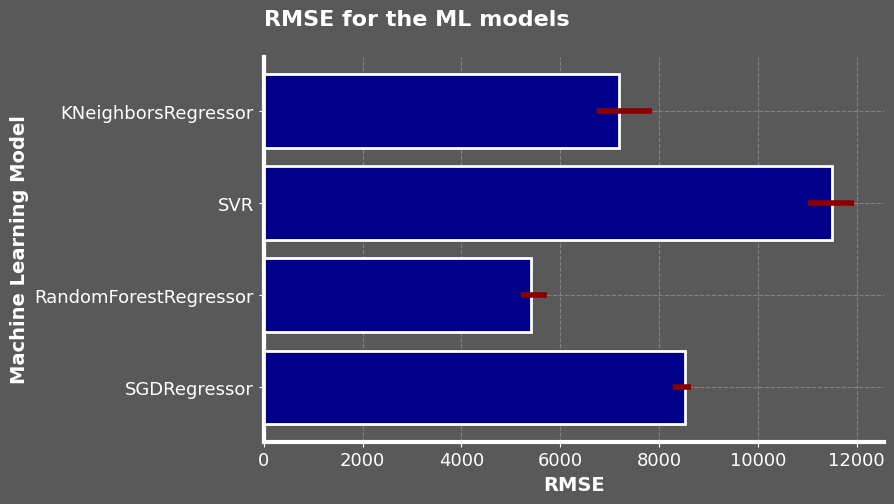

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('0.35')
fig.set_facecolor('0.35')

ax.barh(list(models_scores.keys()), [scores.mean() for scores in models_scores.values()], 
        edgecolor='white', lw=2, color='darkblue', zorder=5)

for est_name, scores_est in models_scores.items():
    rmse_min, rmse_max = scores_est.min(), scores_est.max()
    ax.hlines(est_name, xmin=rmse_min, xmax=rmse_max, color='darkred', 
              linewidth=4, zorder=10)

ax.set_xlabel('RMSE', fontsize=14, color='white', fontweight='bold')
ax.set_ylabel('Machine Learning Model', fontsize=14, color='white', fontweight='bold')
ax.grid(color='white', alpha=0.25, zorder=0, ls='--')
ax.tick_params(labelcolor='white', color='white', labelsize=13)
ax.set_title('RMSE for the ML models\n', fontsize=16, color='white', loc='left', 
             fontweight='bold')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_linewidth(3)
ax.spines[['bottom', 'left']].set_color('white')

In [48]:
print('RandomForestRegressor: ')
print(f'RMSE: {models_scores["RandomForestRegressor"].mean():.2f}')
print(f'std: {models_scores["RandomForestRegressor"].std():.2f}')

RandomForestRegressor: 
RMSE: 5407.56
std: 158.71


The most promising model is the RandomForestClassifier with a mean error **(RMSE) of about 5400** and a standar deviation of about 160 during cross validation (10 folds) so let's work with it.

#### **Univariate RandomForestRegressor models**






nlBy using just one feature, we get an RMSE from 9765 to 11405. As we could expect, the **model** feature is the most relevant feature for a uni-variate RandomForestRegressor model. Other relevant features include **levy**, **airbags**, **manufacturer**, and **prod_year**. All of these features, we could expect to be related with the price of a vehicle (except, maybe, the number of airbags).

On the other hand, the least important features while using a simple univariate RandomForestRegression model seams to be the **drive_wheels** (which can only be left or right), the number of **doors**, the number of **cylinders**, the **leather_interiors** and the **color**. 



In [49]:
rf_univariate_models = {}

for col in data_train.drop(columns='price').columns:
    Xi = data_train[[col]]
    Xi = full_trans_pipeline.fit_transform(Xi)
    yi = data_train.price
    
    model = RandomForestRegressor()
    nmse_scores = cross_val_score(model, Xi, yi, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    mean_rmse = rmse_scores.mean()
    
    rf_univariate_models[col] = mean_rmse
    
rf_univariate_models = pd.Series(rf_univariate_models, name='RMSE').sort_values()
rf_univariate_models

model                9761.109143
levy                10454.656583
airbags             10662.995786
manufacturer        10699.207597
prod_year           10759.746838
fuel_type           10881.879102
mileage             11024.608815
category            11030.634911
engine_volume       11142.761307
gear_box_type       11143.839834
turbo               11297.750581
wheel               11299.805614
color               11352.053328
leather_interior    11355.767327
cylinders           11361.840710
doors               11404.537589
drive_wheels        11405.655616
Name: RMSE, dtype: float64

#### **Hyperparamether Tunning**

First, let's tune the hyperparameters of our RandomForestModel (with all the features).

In [50]:
grid_search = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False],
}

model = RandomForestRegressor()
searcher = GridSearchCV(model, grid_search, scoring='neg_mean_squared_error', 
                        verbose=0, n_jobs=-1)
searcher.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [3, 5, 7, 9, None],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error')

In [51]:
searcher.best_params_

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 1,
 'n_estimators': 250}

In [52]:
model = RandomForestRegressor(**searcher.best_params_)

nmse_scores = cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1,
                              scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-nmse_scores)
mean_rmse = rmse_scores.mean()

mean_rmse

5391.612874072904

### **Learning Curves**

In [53]:
def learning_curve(model, X, y, max_splits=50):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
    
    max_splits = max_splits if X_train.shape[0]>max_splits else 1
    train_sizes = np.arange(int(X_train.shape[0]/max_splits), 
                           int(X_train.shape[0] + X_train.shape[0]//max_splits), 
                           X_train.shape[0]//max_splits)
    
    train_errors = []
    val_errors = []
    for i, train_size in enumerate(train_sizes):
        Xi_train = X_train[:train_size]
        yi_train = y_train[:train_size]
        model.fit(Xi_train, yi_train)
        
        yi_train_pred = model.predict(Xi_train)
        train_error = np.sqrt(mean_squared_error(yi_train, yi_train_pred))
        y_val_pred = model.predict(X_val)
        val_error = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        train_errors.append(train_error)
        val_errors.append(val_error)
        
    return train_sizes, train_errors, val_errors


model = searcher.best_estimator_
train_sizes, train_errors, val_errors = (
    learning_curve(model, X_train, y_train, max_splits=25)
)

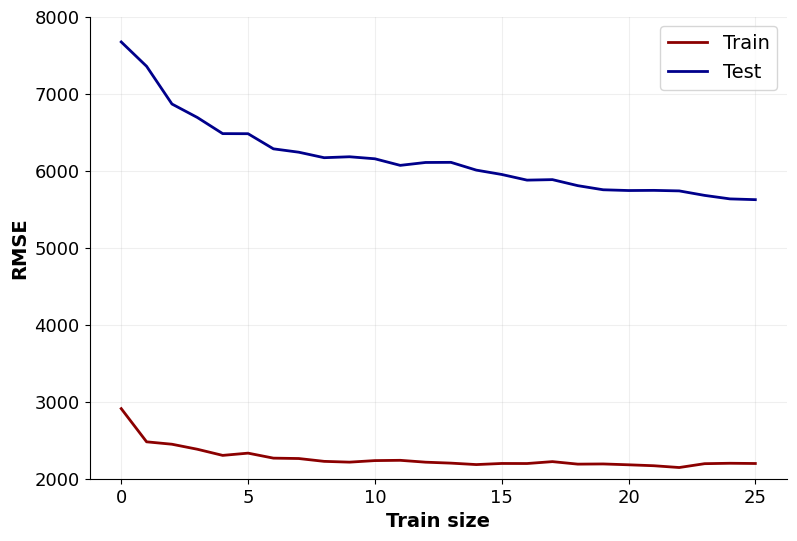

In [54]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(train_errors, label='Train', color='darkred', lw=2)
ax.plot(val_errors, label='Test', color='darkblue', lw=2)
ax.set_ylim(2000, 8000)
ax.grid(alpha=0.2)
ax.tick_params(labelsize=13)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Train size', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=14, fontweight='bold')

plt.legend(fontsize=14)

#### **Final Model and its Performance**

In [55]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

model = RandomForestRegressor(**searcher.best_params_)
X_train = data_train.drop(columns='price')
y_train = data_train.price
X_test = data_test.drop(columns='price')
y_test = data_test.price

X_train = full_trans_pipeline.fit_transform(X_train)
X_test = full_trans_pipeline.transform(X_test)


model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_test = data_test.price
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))


rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mse_test = mean_absolute_error(y_test, y_test_pred)
pmse_test = mean_absolute_percentage_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f'RMSE: {rmse_test:.2f}')
print(f'MAE: {mse_test:.2f}')
print(f'MAPE: {100*pmse_test:.2f}%')
print(f'R2: {r2:.2f}')

RMSE: 5284.51
MAE: 3101.74
MAPE: 71.50%
R2: 0.79


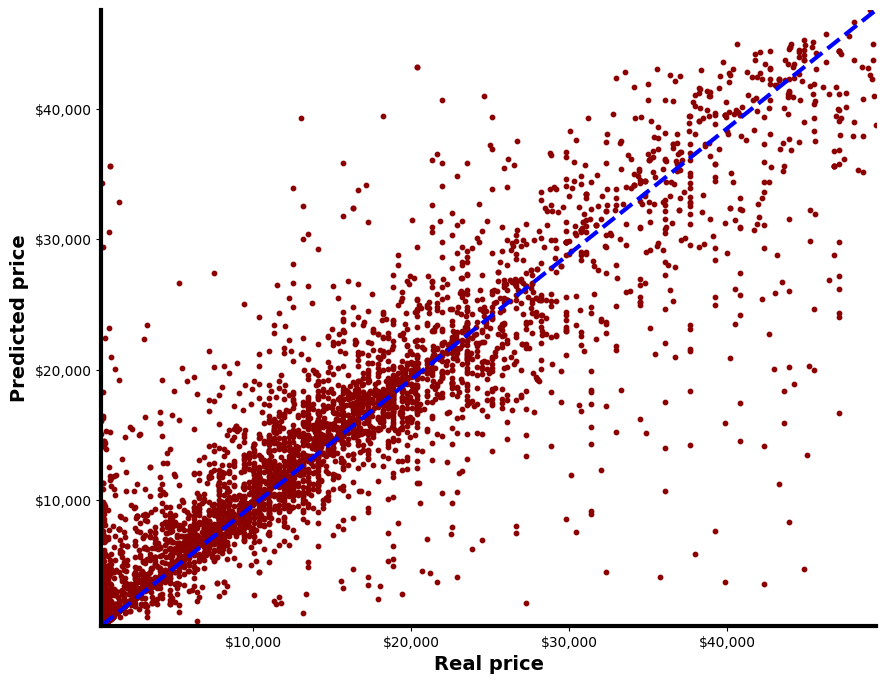

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(y_test, y_test_pred, s=10, marker='o', color='darkred')

ax.set_xlabel('Real price', fontsize=14, fontweight='bold')
ax.set_ylabel('Predicted price', fontsize=14, fontweight='bold')
ax.plot([min(y_test), max(y_test)], 
        [min(y_test_pred), max(y_test_pred)], 
        color='blue', linestyle='--', lw=3)
ax.set_xlim(min(y_test), max(y_test))
ax.set_ylim(min(y_test_pred), max(y_test_pred))

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda xi, li: f'${xi:,.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda xi, li: f'${xi:,.0f}'))

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(3)

The final model has an RMSE of $\$5286$, which is slightly lower than that obtained previously during cross-validation on the training set. As we noted before in the learning curves, this is due to the increase in the training size (since the final model is trained with the full train set). 

### **Conclusions**

* During EDA, we notice some missing/null values, as well as outliers due to incorrect data.
* We performed Data Visualization to gain some insights and answar some questions like the brands and models with most used cars in the market, their average prices, use of leather interior by different manufacturers, and much more, which can be used later for storytelling.
* We create a full preprocessing pipeline to prepare the data for machine learning models, using both sklearn's and created transformers, which included category encoding, handling outliers, imputation of null values, and scaling.
* We selected a model for the regression task, and performed hyperparameter tunning.
* We evaluated the model using different metrics and check for bias/variance using learning curves, detecting a high variance which can be improved by increasing the train size.

* We proposed a final model with an RMSE of 5286, a Mae of 3090 and R2 of 0.79. 